In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Clase para cargar y preparar los datos
class LoadData:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def prepare_data(self, data):
        # Convertir la columna "Ronda" en variables dummy
        data = pd.get_dummies(data, columns=['Ronda'], drop_first=True)
        
        # Eliminar columnas irrelevantes
        data = data.drop(['idPartido', 'Temporada', 'Evento'], axis=1)

        # Separar características y etiquetas
        X = data.drop(['VictoriaLocal', 'Empate', 'VictoriaVisitante', 'GolesLocal', 'GolesVisitante'], axis=1)
        y = data[['GolesLocal', 'GolesVisitante']]  # Seleccionar goles locales y visitantes como etiquetas

        # Escalar características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        # Convertir los datos a tensores
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float32)
        
        return X_train, X_test, y_train, y_test, scaler, X, y

# Cargar los datos
data_loader = LoadData('../dataframe/champions.csv')
data = data_loader.load_data()
X_train, X_test, y_train, y_test, scaler, X, y = data_loader.prepare_data(data)


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


# Clase para entrenar y evaluar el modelo de predicción de goles locales y visitantes
class GoalsPredictionModel:
    def __init__(self, configurations):
        self.configurations = configurations
        self.best_model = None
        self.best_config = None
        self.best_mae = float('inf')

    def train_model(self, X_train, y_train, X_test, y_test):
        for config in self.configurations:
            input_layer = Input(shape=(X_train.shape[1],))
            dense_layer1 = Dense(config['units'], activation='relu')(input_layer)
            dropout_layer1 = Dropout(config['dropout'])(dense_layer1)
            dense_layer2 = Dense(config['units'], activation='relu')(dropout_layer1)
            dropout_layer2 = Dropout(config['dropout'])(dense_layer2)

            # Salida para la predicción de goles locales
            local_goals_output = Dense(1, name='local_goals_output')(dropout_layer2)
            # Salida para la predicción de goles visitantes
            visitor_goals_output = Dense(1, name='visitor_goals_output')(dropout_layer2)
            
            model = Model(inputs=input_layer, outputs=[local_goals_output, visitor_goals_output])

            optimizer = Adam(learning_rate=config['learning_rate'])
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mae'])
            
            history = model.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.1)
            
            self.history = history
            _, local_mae, visitor_mae = model.evaluate(X_test, [y_test[:, 0], y_test[:, 1]])
            total_mae = (local_mae + visitor_mae) / 2
            
            if total_mae < self.best_mae:
                self.best_mae = total_mae
                self.best_model = model
                self.best_config = config
            
        return history
    
    def get_best_model(self):
        return self.best_model
    
    def get_best_config(self):
        return self.best_config

# Definir diferentes configuraciones de red y hiperparámetros
configurations = [
            {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
            {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
            {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
            {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
            {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1},
            {'units': 64, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
            {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20, 'dropout': 0.2},
            {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
            {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 20, 'dropout': 0.3},
            {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
            {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 15, 'dropout': 0.1},
            {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
            {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1}
        ]

goals_model_trainer = GoalsPredictionModel(configurations)
goals_model_trainer.train_model(X_train, y_train, X_test, y_test)

goals_model = goals_model_trainer.get_best_model()
best_config = goals_model_trainer.get_best_config()
print("Mejor configuración:", best_config)
    


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - local_goals_output_mae: 1.3705 - loss: 5.0090 - visitor_goals_output_mae: 1.0073 - val_local_goals_output_mae: 1.0516 - val_loss: 2.7833 - val_visitor_goals_output_mae: 0.8211
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - local_goals_output_mae: 1.0827 - loss: 3.4020 - visitor_goals_output_mae: 0.9391 - val_local_goals_output_mae: 1.0209 - val_loss: 2.6620 - val_visitor_goals_output_mae: 0.8032
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - local_goals_output_mae: 1.0483 - loss: 3.2452 - visitor_goals_output_mae: 0.9234 - val_local_goals_output_mae: 1.0472 - val_loss: 2.6957 - val_visitor_goals_output_mae: 0.8241
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - local_goals_output_mae: 0.9933 - loss: 2.9248 - visitor_goals_output_mae: 0.8840 - val_local_goals_output_mae: 1.0301 - val_loss: 2.6270 - val_visitor_goals_output_mae: 0.8124
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - local_goals_output_mae: 0.97

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE para la predicción de goles del local: 1.0165738
MAE para la predicción de goles del visitante: 0.868963


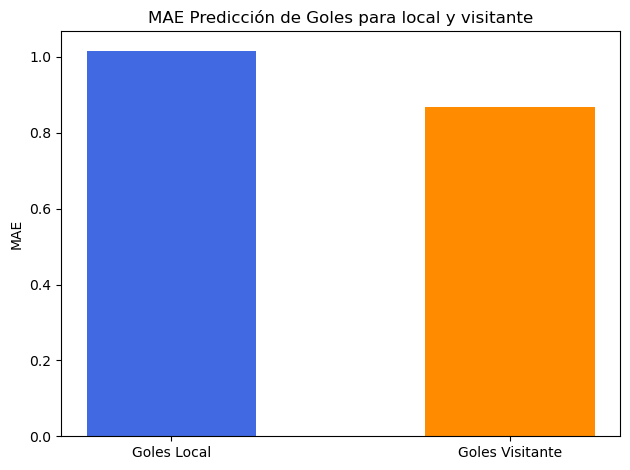

In [32]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

class ModelEvaluation:
    def __init__(self, model):
        self.model = model
    
    def evaluate_model(self, X_test, y_test):
        # Evaluar el modelo
        local_goals_pred, visitor_goals_pred = self.model.predict(X_test)

        # Calcular y mostrar el MAE para cada tipo de predicción
        local_mae = mean_absolute_error(y_test[:, 0], local_goals_pred)
        visitor_mae = mean_absolute_error(y_test[:, 1], visitor_goals_pred)
        
        print("MAE para la predicción de goles del local:", local_mae)
        print("MAE para la predicción de goles del visitante:", visitor_mae)

        # Graficar los resultados
        labels = ['Goles Local', 'Goles Visitante']
        mae_values = [local_mae, visitor_mae]

        plt.bar(labels, mae_values, width=0.5,  color=['royalblue', 'darkorange'])
        plt.ylabel('MAE')
        plt.title('MAE Predicción de Goles para local y visitante')
        plt.tight_layout()
        plt.savefig('../resultados/mae_redes_goles.png')
        plt.show()
    

model_evaluator = ModelEvaluation(goals_model)
model_evaluator.evaluate_model(X_test, y_test)

Un MAE de alrededor de 1 indica que, en promedio, las predicciones del modelo pueden estar desviadas hasta 1 gol por encima o por debajo del valor real. Esto sugiere que las predicciones del modelo podrían variar en un rango de aproximadamente ±1 gol de los valores reales. Lo mismo con los goles del viistante.

In [33]:
# Guardar el modelo
tf.keras.models.save_model(goals_model, '../modelos/modelo_dnn_goals.keras')
model = tf.keras.models.load_model('../modelos/modelo_dnn_goals.keras')

In [34]:
import pandas as pd

# Cargar los datos
df = pd.read_csv("../dataframe/champions_23_24.csv")
df = pd.concat([df, data], ignore_index=True)

import pandas as pd

# Suponiendo que tu DataFrame se llama df
df = df.sort_values(by=['Temporada', 'Ronda'], ascending=[True, True])
df = pd.get_dummies(df, columns=['Ronda'], drop_first=True)

df

,idPartido,Temporada,Local,Visitante,Evento,GolesLocal,GolesVisitante,VictoriaLocal,Empate,VictoriaVisitante,...,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores,Ronda_Group stage,Ronda_Quarter-finals,Ronda_Round of 16,Ronda_Semi-finals
2617,2618,2003-01-01,27,12,Arena AufSchalke (Neutral Site),0,3,0,0,1,...,16.67,0.50,0.67,1.42,765.322245,34.787375,False,False,False,False
2493,2494,2003-01-01,38,190,Jan Breydelstadion,1,1,0,1,0,...,25.00,0.29,0.25,1.14,491.566535,23.407930,True,False,False,False
2494,2495,2003-01-01,76,11,Stadion Letná,0,1,0,0,1,...,16.67,0.45,0.17,1.36,694.733032,33.082525,True,False,False,False
2495,2496,2003-01-01,36,12,Stadion FK Partizan,1,1,0,1,0,...,16.67,0.58,0.67,1.58,765.322245,34.787375,True,False,False,False
2496,2497,2003-01-01,49,151,Ibrox Stadium,2,1,1,0,0,...,25.00,0.57,0.75,1.14,512.353052,24.397764,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112,2023-01-01,24,7,Stadium Metropolitano,2,1,0,0,1,...,0.00,0.57,0.75,1.29,540.296221,24.558919,False,False,True,False
120,121,2023-01-01,3,1,Allianz Arena,0,0,0,1,0,...,0.00,0.73,0.50,2.00,685.444331,31.156560,False,False,False,True
121,122,2023-01-01,14,28,Signal Iduna Park,0,0,0,1,0,...,16.67,0.45,0.50,1.73,698.621042,33.267669,False,False,False,True
122,123,2023-01-01,28,14,Parc des Princes,0,0,0,1,0,...,0.00,0.45,0.50,1.36,642.492339,27.934450,False,False,False,True


In [35]:
def datos_usuario(df, equipo_local, equipo_visitante):
    # Filtrar el DataFrame para obtener la última fila donde el equipo local y visitante coincidan con los ingresados por el usuario
    filtro_ultimo_partido = ((df['Local'] == equipo_local) & (df['Visitante'] == equipo_visitante)) | ((df['Local'] == equipo_visitante) & (df['Visitante'] == equipo_local))

    # Obtener el último partido entre los equipos ingresados por el usuario
    ultimo_partido_entre_equipos = df[filtro_ultimo_partido].iloc[-1]

    # Obtener los valores para las columnas %_Victorias_Local, %_Empate, %_Victoria_Visitante
    valores_prediccion = ultimo_partido_entre_equipos[['%_Victorias_Local', '%_Empate', '%_Victoria_Visitante', 'Ronda_Group stage', 'Ronda_Quarter-finals',	'Ronda_Round of 16', 'Ronda_Semi-finals']]

    if ultimo_partido_entre_equipos['Local'] == equipo_local and ultimo_partido_entre_equipos['Visitante'] == equipo_visitante:
        porcentajes_de_los_dos = ultimo_partido_entre_equipos[['%_Equipo1_Ganado', '%_Equipo2_Ganado']]

    elif ultimo_partido_entre_equipos['Local'] == equipo_visitante and ultimo_partido_entre_equipos['Visitante'] == equipo_local:
        porcentajes_de_los_dos = ultimo_partido_entre_equipos[['%_Equipo1_Ganado', '%_Equipo2_Ganado']]
        porcentajes_de_los_dos = porcentajes_de_los_dos.rename({'%_Equipo1_Ganado': '%_Equipo2_Ganado', '%_Equipo2_Ganado': '%_Equipo1_Ganado'})


    # 3. Filtrar el DataFrame para obtener las estadísticas del equipo local
    filtro_local = (df['Local'] == equipo_local) | (df['Visitante'] == equipo_local)
    ultima_aparicion_local = df[filtro_local].iloc[-1]
    if ultima_aparicion_local['Local'] == equipo_local:
        estadisticas_equipo_local = ultima_aparicion_local[['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']]
    elif ultima_aparicion_local['Visitante'] == equipo_local:
        estadisticas_equipo_local = ultima_aparicion_local[['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']]
        #Cambiar el numero del nombre de las columnas porque si es el local del usuario pasara a ser las columnas con 1 en vez de 2
        estadisticas_equipo_local.index = ['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']

    # 4. Filtrar el DataFrame para obtener las estadísticas del equipo visitante
    filtro_visitante = (df['Local'] == equipo_visitante) | (df['Visitante'] == equipo_visitante)
    ultima_aparicion_visitante = df[filtro_visitante].iloc[-1]
    if ultima_aparicion_visitante['Local'] == equipo_visitante:
        estadisticas_equipo_visitante = ultima_aparicion_visitante[['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']]
        estadisticas_equipo_visitante = estadisticas_equipo_visitante.rename({'%_1_G_Temporada': '%_2_G_Temporada', '%_1_G_Temporada_L': '%_2_G_Temporada_L', '%_1_E_Temporada_L': '%_2_E_Temporada_L', '%_1_P_Temporada_L': '%_2_P_Temporada_L', '1_Media_G': '2_Media_G', '1_Media_G_Local': '2_Media_G_Local', '1_Media_Goles_PP': '2_Media_Goles_PP', '1_ValorJugadores': '2_ValorJugadores', '1_MediaJugadores': '2_MediaJugadores'})
    elif ultima_aparicion_visitante['Visitante'] == equipo_visitante:
        estadisticas_equipo_visitante = ultima_aparicion_visitante[['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']]


    # Combinar las estadísticas de ambos equipos para predecir el resultado del partido
    datos_partido = pd.concat([estadisticas_equipo_local, estadisticas_equipo_visitante, valores_prediccion, porcentajes_de_los_dos])

    # Crear un nuevo DataFrame vacío con las columnas especificadas en el orden deseado
    nuevo_dataframe = pd.DataFrame(columns=['Local', 'Visitante', '%_Victorias_Local', '%_Empate', '%_Victoria_Visitante',
                                            '%_Equipo1_Ganado', '%_Equipo2_Ganado', '%_1_G_Temporada', '%_1_G_Temporada_L',
                                            '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP',
                                            '1_ValorJugadores', '1_MediaJugadores', '%_2_G_Temporada', '%_2_G_Temporada_L',
                                            '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP',
                                            '2_ValorJugadores', '2_MediaJugadores', 'Ronda_Group stage', 'Ronda_Quarter-finals', 'Ronda_Round of 16', 'Ronda_Semi-finals'])

    # Agregar una fila con los valores proporcionados al nuevo DataFrame
    nuevo_dataframe.loc[0] = [equipo_local, equipo_visitante, datos_partido['%_Victorias_Local'], datos_partido['%_Empate'],
                            datos_partido['%_Victoria_Visitante'], datos_partido['%_Equipo1_Ganado'], datos_partido['%_Equipo2_Ganado'],
                            datos_partido['%_1_G_Temporada'], datos_partido['%_1_G_Temporada_L'], datos_partido['%_1_E_Temporada_L'],
                            datos_partido['%_1_P_Temporada_L'], datos_partido['1_Media_G'], datos_partido['1_Media_G_Local'],
                            datos_partido['1_Media_Goles_PP'], datos_partido['1_ValorJugadores'], datos_partido['1_MediaJugadores'],
                            datos_partido['%_2_G_Temporada'], datos_partido['%_2_G_Temporada_L'], datos_partido['%_2_E_Temporada_L'],
                            datos_partido['%_2_P_Temporada_L'], datos_partido['2_Media_G'], datos_partido['2_Media_G_Local'],
                            datos_partido['2_Media_Goles_PP'], datos_partido['2_ValorJugadores'], datos_partido['2_MediaJugadores'],
                            datos_partido['Ronda_Group stage'], datos_partido['Ronda_Quarter-finals'], datos_partido['Ronda_Round of 16'], datos_partido['Ronda_Semi-finals']]


    return nuevo_dataframe


datos_usuario(df, 14, 28)

,Local,Visitante,%_Victorias_Local,%_Empate,%_Victoria_Visitante,%_Equipo1_Ganado,%_Equipo2_Ganado,%_1_G_Temporada,%_1_G_Temporada_L,%_1_E_Temporada_L,...,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores,Ronda_Group stage,Ronda_Quarter-finals,Ronda_Round of 16,Ronda_Semi-finals
0,14,28,60.0,40.0,0.0,20.0,40.0,45.45,50.0,50.0,...,20.0,0.45,0.6,1.73,698.621042,33.267669,False,False,False,True


In [36]:

def main():
    # 1. Pedir al usuario que ingrese el equipo local
    print("Seleccione el equipo local:")
    equipos_disponibles = df['Local'].unique()
    print(equipos_disponibles)

    equipo_local = int(input("Ingrese el nombre del equipo local: "))
    equipo_visitante = int(input("Ingrese el nombre del equipo visitante: "))

    nuevo_dataframe = datos_usuario(df, equipo_local, equipo_visitante)

    X_prediccion = scaler.transform(nuevo_dataframe)
    class_probabilities_prediccion = model.predict(X_prediccion)

    print(f"Probabilidades de clase predichas para el partido {equipo_local} VS. {equipo_visitante}:")
    print("Goles locales:", class_probabilities_prediccion[0])
    print("Goles visitantes:", class_probabilities_prediccion[1])


if __name__ == "__main__":
    main()

Seleccione el equipo local:
[ 27  38  76  36  49  94   8   1   2  69   3  31  21  46  43   9  95  61
  44 186   7  85  50  16  12   6  99  11  17 190 151  29  25  92  28  32
   4 303  37  88   5  93  98 103 323 368  10  47  51 350 355 154  55  87
 153  19  18  60 142  57 305  80  89 294 140 322  39 301 252  24  48 122
 298  53 189 378 310 346 110 484 374 316 308 123 339  33 299 336  14 235
  15 513  90 160 125 469 482  62 296 105  40 297 188  34 306  59 126 366
  22  68 300  20  67 464 184 108 485 321 352 379  97 295  41 470 328 191
 307]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Probabilidades de clase predichas para el partido 14 VS. 28:
Goles locales: [[1.0130737]]
Goles visitantes: [[0.96239597]]


In [37]:
#!jupyter nbconvert --to script dnn_goles.ipynb

[NbConvertApp] Converting notebook dnn_goles.ipynb to script
[NbConvertApp] Writing 16196 bytes to dnn_goles.py
